# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
from IPython.display import display
import  matplotlib.pyplot as plt

try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\\t')  # путь в яндексе
except:
    data = pd.read_csv('real_estate_data.csv', sep='\\t')   # путь дома

def data_info(dt):
    dt.info()
    # случайные строчки датафрейма, в скобках кол-во строк
    display(dt.sample(5))
    # процент пропусков в столбце для наглядности
    display(pd.DataFrame(round((dt.isna().mean() * 100), 2)).style.background_gradient('coolwarm')) 
   
    
data_info(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21661,5,5265000.0,53.47,2018-02-21T00:00:00,2,2.7,25.0,29.67,21,NaN,...,8.95,2.0,Санкт-Петербург,39180.0,16002.0,0.0,NaN,1.0,930.0,60.0
12090,9,4350000.0,33.00,2016-11-26T00:00:00,1,NaN,22.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,9258.0,10592.0,1.0,458.0,0.0,NaN,181.0
7888,1,1000000.0,31.40,2017-12-07T00:00:00,1,2.6,4.0,NaN,3,NaN,...,NaN,1.0,городской посёлок Назия,NaN,NaN,NaN,NaN,NaN,NaN,47.0
7870,10,3200000.0,36.70,2018-10-09T00:00:00,1,NaN,22.0,14.70,22,NaN,...,10.90,2.0,Санкт-Петербург,41561.0,20878.0,0.0,NaN,1.0,394.0,50.0
527,15,4200000.0,57.00,2018-08-07T00:00:00,3,2.5,5.0,40.00,2,NaN,...,6.00,NaN,Санкт-Петербург,19455.0,18458.0,1.0,534.0,1.0,518.0,94.0


,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,38.8
floors_total,0.36
living_area,8.03
floor,0
is_apartment,88.29


### Вывод

- переименуем несколько названий столбцов в привычный вид 
- заполним пропуски в ceiling_height, floors_total, balcony, is_apartment, parks_around_3000, ponds_around_3000
- в locality_name заменим пропущеные значение на 'неизвестно'
- first_day_exposition - приведем к формату год-месяц-день


### Шаг 2. Предобработка данных

In [2]:
# проверем название столбоцов
print(data.columns)
# переименуем столбцы в привычный вид 
data.rename(columns = {'cityCenters_nearest' : 'city_centers_nearest', 
                       'parks_around3000' : 'parks_around_3000',
                      'ponds_around3000' : 'ponds_around_3000'}, inplace = True)


Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


In [3]:
# заполним пропуски в ceiling_height и floors_total на медиану
data = data.fillna(
    {
        'ceiling_height' : data['ceiling_height'].median(),
        'floors_total' : data['floors_total'].median(),        
    }
)


In [4]:
# заполним пропуски в balcony, is_apartment, parks_around_3000 и ponds_around_3000 на 0
data = data.fillna(
    {
        'is_apartment' : 0,
        'balcony' : 0,
        'parks_around_3000' : 0,
        'ponds_around_3000' : 0,
    }
)


In [5]:
# locality_name заполним значением'неизвестно'
data['locality_name'] = data['locality_name'].fillna('неизвестно')

In [6]:
# переведем first_day_exposition в формат даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y.%m.%d')


In [7]:
display(pd.DataFrame(round((data.isna().mean() * 100), 2)).style.background_gradient('coolwarm')) 


,0
total_images,0
last_price,0
total_area,0
first_day_exposition,0
rooms,0
ceiling_height,0
floors_total,0
living_area,8.03
floor,0
is_apartment,0


### Вывод по пропускам

- переименуем несколько названий столбцов в привычный вид;
- заполним пропуски в 'ceiling_height' и 'floors_total' на медиану т.к. высота потолков варьируется в достаточно узких пределах, а также в датафрейме нет указания на класс жилья(эконом, комфорт, бизнес), что не позволяет взять медиану в зависимости от категории. Аналогично и для этажности дома. К тому же медиана равна 9, что вполне соответствует действительности.(Средняя высота «вторички» в городах-миллионниках - Санкт-Петербург - 10 этажей, по данным сайта domofond);
- заполним пропуски в 'balcony','is_apartment', 'parks_around_3000' и 'ponds_around_3000' на 0, т к если нет балконов, то человек мог и не указать их, а столбец апартаменты имеет булев тип и если он не заполнен, значит квартира не относится к апартаментам. по количеству парков и прудов укажим 0, т к возможно их и нет в радиусе 3 км;
- в locality_name заменим пропущеные занечение на 'неизвестно';
- переведем first_day_exposition в формат даты;
- living_area и kitchen_area оставим без изменений, т к посчитать жилую площадь и площадь кухни невозможно, из-за отсутствия информации по площади других комнат;
- airports_nearest, city_centers_nearest, parks_nearest, ponds_nearest - расстояния до объектов возможно восстановить только в ручном режиме, но это долго.

In [8]:
# изменим тип данный на числовой через функцию
def to_int(data_f, colum):
    data_f[colum] = data_f[colum].astype('int')
    

to_int(data, 'balcony')
to_int(data, 'floors_total')
to_int(data, 'parks_around_3000')
to_int(data, 'ponds_around_3000')

# изменим тип данных на булев
data['is_apartment'] = data['is_apartment'].astype('bool')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
city_centers_nearest    18180 non-null float64
parks_around_3000       23699 non-null int64
parks_nearest           8079 non-null float64
ponds_around_3

In [9]:
# переведем в километры данные из столбцов с расстояниями в метрах 
def kilometr(dt, metr):
    dt[metr] = round(dt[metr] / 1000, 2)
    

kilometr(data, 'airports_nearest')
kilometr(data, 'city_centers_nearest')
kilometr(data, 'parks_nearest')
kilometr(data, 'ponds_nearest')


In [10]:
# округлим значения площадей до 1 знака после запятой, для упрощения восприятия цифр
def sign(dt, square_met):
    dt[square_met] = round(dt[square_met], 1)
    

sign(data, 'kitchen_area')
sign(data, 'living_area')
sign(data, 'total_area')

display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,25.0,0,Санкт-Петербург,18.86,16.03,1,0.48,2,0.76,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,11.0,2,посёлок Шушары,12.82,18.60,0,NaN,0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,8.3,0,Санкт-Петербург,21.74,13.93,1,0.09,2,0.57,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,False,...,NaN,0,Санкт-Петербург,28.10,6.80,2,0.08,3,0.23,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,41.0,0,Санкт-Петербург,31.86,8.10,2,0.11,1,0.05,121.0


### Вывод

- изменим тип данный на числовой через функцию для столбцов 'balcony', 'days_exposition', 'floors_total', 'parks_around_3000','ponds_around_3000' - в данных столбцах исключительно целые значения;
- is_apartment заменим на булев тип данный, тк столбец содержит только информацию да/нет;
- переведем в километры данные из столбцов с расстояниями в метрах и округлим значения площадей до 2 знаков после запятой -для упрощения информации
- округлим значения площадей до 1 знака после запятой, для упрощения восприятия цифр

### Шаг 3. Посчитаем и добавим в таблицу

In [11]:
#цена квадратного метра
data['square_meter'] = (data['last_price'] / data['total_area']).astype('int')

# день недели, месяц и год
data['weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

# категоризировали по этажности на первый, последний и другие
def floors(row):
    floor = row['floor']
    floors_total = row['floors_total']
    
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

    
data['floor_category'] = data.apply(floors, axis=1) 

# отношение жилой к общей площади
data['ratio_liv_total'] = round(data['living_area'] / data['total_area'], 2)

# отношение площади кухни к общей площади
data['ratio_kitch_total'] = round(data['kitchen_area'] / data['total_area'], 2)

display(data.head(5))


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around_3000,ponds_nearest,days_exposition,square_meter,weekday,month,year,floor_category,ratio_liv_total,ratio_kitch_total
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,2,0.76,NaN,120370,3,3,2019,другой,0.47,0.23
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0,NaN,81.0,82920,1,12,2018,первый,0.46,0.27
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,2,0.57,558.0,92785,3,8,2015,другой,0.61,0.15
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,NaN,9,False,...,3,0.23,424.0,408176,4,7,2015,другой,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1,0.05,121.0,100000,1,6,2018,другой,0.32,0.41


### Шаг 4. Провем исследовательский анализ данных и выполним инструкции:

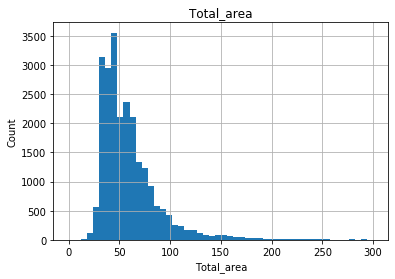

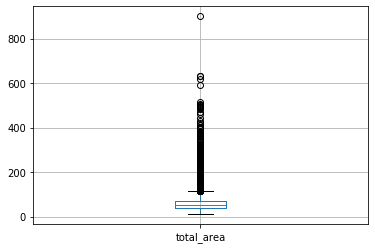

In [12]:

# построим гистограмму по площади квартиры
data['total_area'].hist(bins = 50, range =(0, 300))
plt.title('Total_area')
plt.xlabel('Total_area')
plt.ylabel('Count')
plt.show()

# отобразим диаграмму ящик с усами
data.boxplot(column = 'total_area')
plt.show()


- наиболее часто встречаются квартиры с площадью от 28 до 47 м кв, это студии, 1 и маленькие 2-х комн. квартиры, есть еще небольшой пик по большим 2-ным квартирам от 52 до 60 м кв. Есть редкие и выбивающиеся занчения и за пределами 200 м кв.

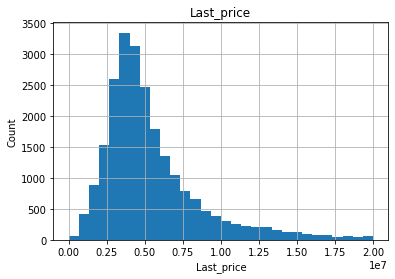

In [13]:
# построим гистограмму по цене квартиры
data['last_price'].hist(bins = 30, range =(0, 20000000))
plt.title('Last_price')
plt.xlabel('Last_price')
plt.ylabel('Count')
plt.show()

- наиболее часто встречаются квартиры стоимостью примерно от 2,8 млн до 4,6 млн. Есть редкие и выбивающиеся занчения и за пределами 20 млн.

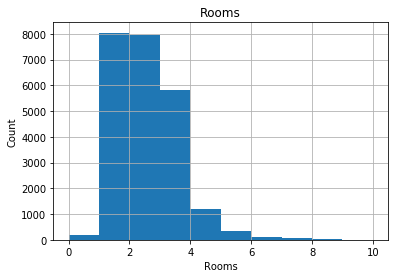

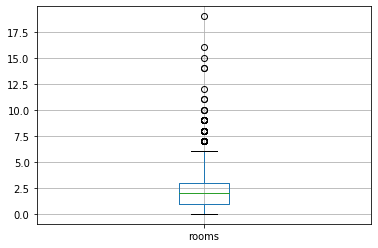

In [14]:
# построим гистограмму по кол-ву комнат
data['rooms'].hist(bins = 10, range = (0, 10))
plt.title('Rooms')
plt.xlabel('Rooms')
plt.ylabel('Count')
plt.show()

# отобразим диаграмму ящик с усами
data.boxplot(column = 'rooms')
plt.show()

- Наиболее часто продаются 1 и 2-ные квартиры. Есть редкие и выбивающиеся занчения и за пределами 10 комнат.

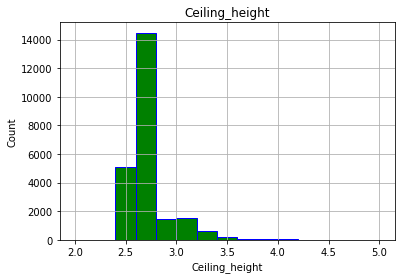

In [15]:
# построим гистограмму по высоте потолка
data['ceiling_height'].hist(bins = 15, range =(2, 5), color = 'Green', edgecolor = 'Blue')
plt.title('Ceiling_height')
plt.xlabel('Ceiling_height')
plt.ylabel('Count')
plt.show()

- Наиболее часто встречаются потолки высотой примерно от 2,6 до 2,8 м. Есть редкие и выбивающиеся занчения и за пределами 5 метров и до 2 метров.

#### Изучим время продажи квартир

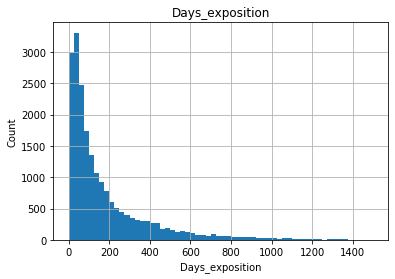

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


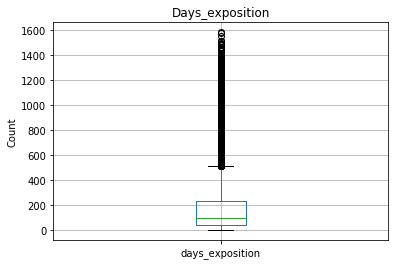

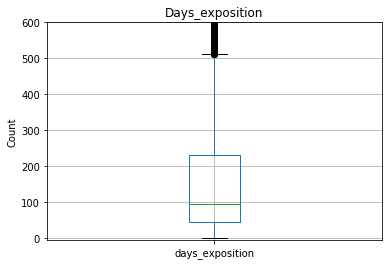

Процент квартир проданных за 4 дня - 1.43%


In [16]:
# построим гистограмму по времени продаж
data['days_exposition'].hist(bins = 60, range = (0, 1500))
plt.title('Days_exposition')
plt.xlabel('Days_exposition')
plt.ylabel('Count')
plt.show()

# числовое описание столбца
print(data['days_exposition'].describe())

# отобразим диаграмму ящик с усами
data.boxplot(column = 'days_exposition')
plt.title('Days_exposition')
plt.ylabel('Count')
plt.show()
print()

# отобразим диаграмму ящик с усами с увеличенным масштабом
data.boxplot(column = 'days_exposition')
plt.ylim(-5, 600)
plt.title('Days_exposition')
plt.ylabel('Count')
plt.show()

print('Процент квартир проданных за 4 дня - {:.2%}'.
      format(round(len(data.query('days_exposition <= 4')) / len(data), 4)))

- Нижний «ус» упирается в 0, минимальное значение. Верхний заканчивается около 510;
- в половине случаев квартира продается в течении 95 дней;
- в 75% случаев продается за 232 дней;
- Продажи продолжительностью 800 дней — уже редки. Дольше 1000 дней почти не продаются. А на участке более 1200-т дней гистограмма сливается с нулём (это не значит, что там ровно 0);
- посчитав долю дней, которое объявление было размещено, можно сделать вывод, что до 4 дней практически не бывает продаж квартир, о чем свидетельствует значение - 1.43%. 

#### Уберем редкие и выбивающие значения

Процент квартир с площадью более 200 кв м - 0.96%
Процент квартир с кол-вом комнат 6 и более - 0.82%

Гистограмма высота потолка от 0 до 2,2 м


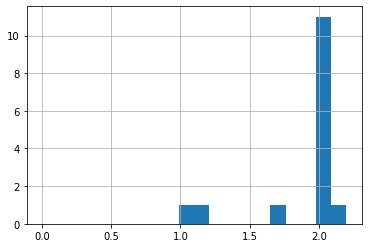

Процент квартир с высотой потолка менее 2 м - 0.06%

Гистограмма высоты потолка более 4 м


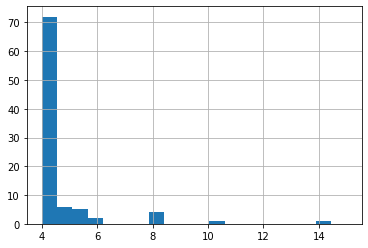

Процент квартир с высотой потолка более 4 м - 0.48%

Гистограмма по кол-ву фотографий


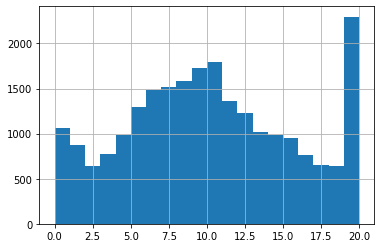

Процент объявлений, где менее 3 фотогр.- 14.09%


In [17]:
# в дальнейшем нам понадобится столбцы: total_area, rooms, city_centers_nearest, ceiling_height

# Посчитаем долю квартир с площадью более 200 м кв
print('Процент квартир с площадью более 200 кв м - {:.2%}'.format(round(len(data.query('total_area > 200')) / len(data), 4)))

# Посчитаем долю квартир, где комнат 6 и более
print('Процент квартир с кол-вом комнат 6 и более - {:.2%}'.format(round(len(data.query('rooms >= 6')) / len(data), 4)))

print()
print('Гистограмма высота потолка от 0 до 2,2 м')
# построение гистограммы по высоте потолка
data['ceiling_height'].hist(bins = 20, range = (0, 2.2))
plt.show()

# Посчитаем долю квартир по высоте потолка менее 2 м
print('Процент квартир с высотой потолка менее 2 м - {:.2%}'.
      format(round(len(data.query('ceiling_height <= 2')) / len(data), 4)))

print()
print('Гистограмма высоты потолка более 4 м')
# построение гистограммы по высоте потолка
data['ceiling_height'].hist(bins = 20, range = (4, 15))
plt.show()

# Посчитаем долю квартир по высоте потолка 4 м и более
print('Процент квартир с высотой потолка более 4 м - {:.2%}'.
      format(round(len(data.query('ceiling_height >= 4')) / len(data), 4)))

print()
print('Гистограмма по кол-ву фотографий')
# построение гистограммы по кол-ву фотографий в объявлении
data['total_images'].hist(bins = 20, range = (0, 20))
plt.show()

# Посчитаем долю квартир по кол-ву фотографий в объявлении
print('Процент объявлений, где менее 3 фотогр.- {:.2%}'.
      format(round(len(data.query('total_images <= 3')) / len(data), 4)))

# создим новый датафрейм с отфильтрованными значениями
good_data = data.query('total_area < 200 and rooms < 6 and (2 < ceiling_height < 4) and (total_images > 3)')


- можно отбросить квартиры с площадью более 200 метров квадр, т к это очень редкие квартиры их доля менее 1% и можно предположить,что это ошибочные данные или не соответствующие действительности 
- можно отбросить квартиры c 6 и более комнатами, т к это очень редкие квартиры их доля менее 1% и можно предположить,что это ошибочные данные или не соответствующие действительности
- можно отбросить квартиры с высотой потолка менее 2 м, т к это очень редкие квартиры их доля менее 1% и можно предположить,что это ошибочные данные
- можно отбросить квартиры с высотой потолка 4 м и более, т к это очень редкие квартиры их доля менее 1% и можно предположить,что это ошибочные данные
- изучив столбец total_images, мы пришли к выводу, что малое кол-во фотографий - это сомнительно. Без фотографий невозможно оценить квартиру. Уберем объявления с малым кол-вом фотографий, где всего 3 фотогр. Т к это может свидетельствовать об мошенничестве.

#### Факторы влияющие на стоимость квартиры

Средняя взаимосвязь 0.65, между total_area и last_price.
Слабая взаимосвязь 0.36, между rooms и last_price.
Слабая взаимосвязь -0.26, между city_centers_nearest и last_price.


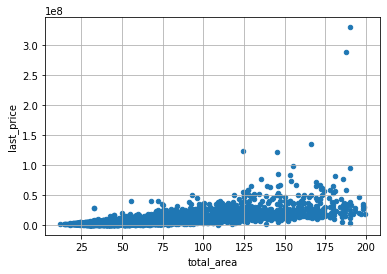

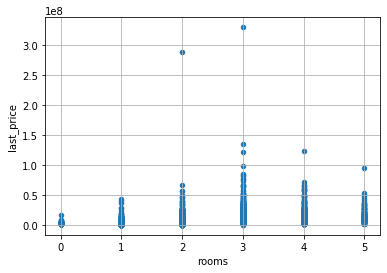

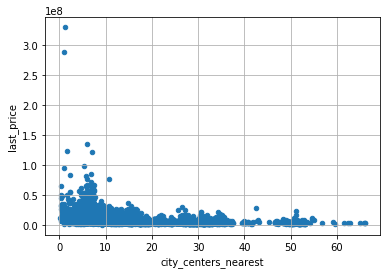

In [18]:
# рассмотрим влияние на стоимость квартиры площади, кол-ва комнат и удаленность от центра 
def corr_price(dt, col_1, col_2):
    cor = dt[col_1].corr(dt[col_2])
    
    if abs(cor) <= 0.2:
        print('Очень слабая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    elif abs(cor) <= 0.5:
        print('Слабая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    elif abs(cor) <= 0.7:
        print('Средняя взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    elif abs(cor) <= 0.9:
        print('Высокая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    elif abs(cor) > 0.9:
        print('Очень высокая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    
    dt.plot(x=col_1, y=col_2, kind='scatter', grid = True) 


corr_price(good_data, 'total_area', 'last_price')
corr_price(good_data, 'rooms', 'last_price')
corr_price(good_data, 'city_centers_nearest', 'last_price')


- между стоимостью и площадью средняя положительная корреляция- 0.65, с увеличением площади стоимость квартиры растет уже не так сильно
- между стоимостью и кол-вом комнат имеется слабая положительная корреляция - 0.36, стоимость растет до 3-х комнатных квартир квартир
- между стоимостью и удаленностью от центра имеется слабая отрицательная корреляция - (-0.26). С увеличением расстояния стоимость квартир падает.
- выделяются 2 квартиры площадью примерно 180 - 185 кв м и расположенные близко к центру города

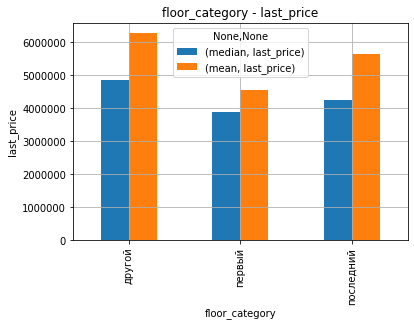

In [19]:
# рассмотрим влияния на стоимость квартиры от этажа 
corr_floor = good_data.pivot_table(index = 'floor_category', values = 'last_price', aggfunc = ['median', 'mean'])
corr_floor.plot(kind='bar', grid = True, legend = True)
plt.title('floor_category - last_price')
plt.ylabel('last_price')
plt.show()

- стоимость на первом этаже ниже, чем на последнем. Более дорогие квартиры расположены не на первом и не на последнем этажах

Очень слабая взаимосвязь -0.01413
Очень слабая взаимосвязь -0.00039
Очень слабая взаимосвязь -0.03031


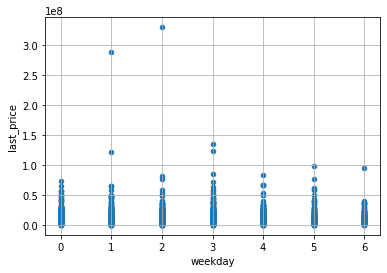

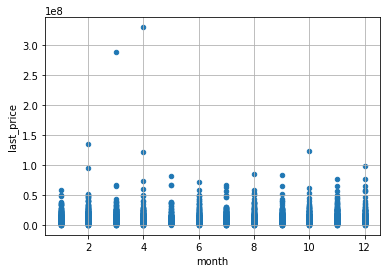

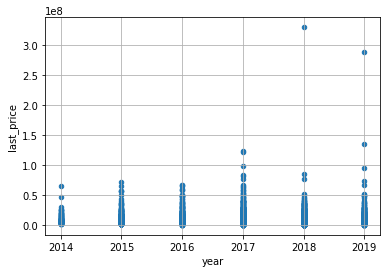

In [20]:
# рассмотрим влияние на стоимость квартиры от даты размещения
def corr_date(dt, col_1, col_2):
    cor = dt[col_1].corr(dt[col_2])
    
    if abs(cor) <= 0.2:
        print('Очень слабая взаимосвязь {}'.format(round(cor, 5)))
    elif abs(cor) <= 0.5:
        print('Слабая взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) <= 0.7:
        print('Средняя взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) <= 0.9:
        print('Высокая взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) > 0.9:
        print('Очень высокая взаимосвязь {}'.format(round(cor, 2)))
    dt.plot(x=col_2, y=col_1, kind = 'scatter', grid = True)
    
    
corr_date(good_data, 'last_price', 'weekday') 
corr_date(good_data, 'last_price', 'month') 
corr_date(good_data, 'last_price', 'year') 


- между стоимостью и днями недели, месяца или года корреляция отсутствует. Можно сказать, что даты никак не влияют на стоимость квартир

#### Найдем 10 населенных пунктов с наибольшим числом объявлений

,count,count_squa_met,median,median_squa_met,mean,mean_squa_met
locality_name,,,,,,
Санкт-Петербург,13312,13312,5500000.0,105051.5,7.226677e+06,113743.669847
посёлок Мурино,424,424,3450000.0,85890.0,3.747651e+06,85943.431604
посёлок Шушары,347,347,4000000.0,78758.0,4.201426e+06,80634.625360
Всеволожск,341,341,3480000.0,66666.0,3.776572e+06,68116.096774
Пушкин,298,298,5350000.0,100763.5,6.258026e+06,103922.587248
Колпино,272,272,3670000.0,75174.5,3.900998e+06,75716.209559
посёлок Парголово,269,269,4199000.0,92282.0,4.591477e+06,91663.639405
Гатчина,265,265,3150000.0,68429.0,3.535975e+06,69009.309434
деревня Кудрово,243,243,3745000.0,92643.0,4.235680e+06,92728.687243


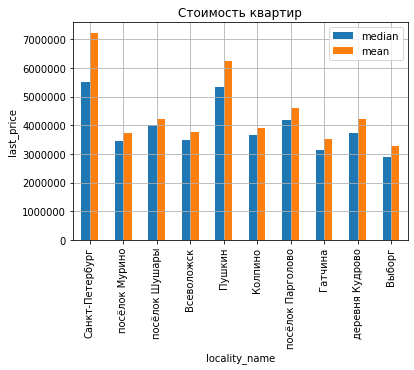

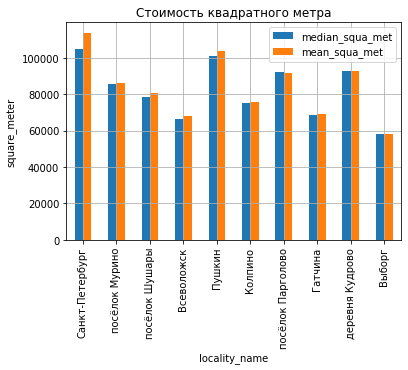

In [21]:
# отберем 10 населенных пунктов с наибольшим числом объявлений
locality_table = good_data.pivot_table(index = 'locality_name', 
                                       values = ['last_price', 'square_meter'], aggfunc = ['count','median', 'mean'])

locality_table.columns = ['count', 'count_squa_met', 'median', 'median_squa_met', 'mean', 'mean_squa_met']
locality_table_10 = locality_table.sort_values(by = 'count', ascending=False).head(10)
display(locality_table_10)

locality_table_10.plot(y = ['median', 'mean'], kind='bar', grid = True, 
                       legend = True, title = 'Стоимость квартир')

plt.ylabel('last_price')
plt.show()

locality_table_10.plot(y = ['median_squa_met', 'mean_squa_met'], kind='bar', grid = True, 
                       legend = True, title = 'Стоимость квадратного метра')
plt.ylabel('square_meter')
plt.show()

- стоимость квартир в Санкт-Петербурге по медиане немного дороже, чем в Пушкино, а по средн. арифметич. разрыв гораздо больше;
- по стоимости за кв м ситуация аналогична, лишь в СПБ и Пушкино цена более 100 тыс за кв м;
- по всей полученным цифрам самая дешевая недвижимость в Выборге, цена кв м меньше 60 тыс за кв м.

In [22]:
# создадим ноый столбец city_cent_near_km расстояние от центра переведем в км и округлим до целого числа
good_data['city_cent_near_km'] = round(data['city_centers_nearest'], 0)
display(good_data.head())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,square_meter,weekday,month,year,floor_category,ratio_liv_total,ratio_kitch_total,city_cent_near_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0.76,NaN,120370,3,3,2019,другой,0.47,0.23,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,81.0,82920,1,12,2018,первый,0.46,0.27,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,0.57,558.0,92785,3,8,2015,другой,0.61,0.15,14.0
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,55.0,95065,0,9,2018,другой,0.47,0.30,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.65,26,10.6,6,False,...,NaN,155.0,99195,3,11,2017,другой,0.28,0.39,19.0


#### Определим квартиры относящиеся к центру города

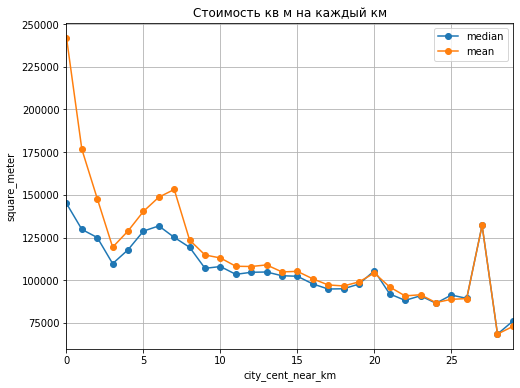

In [23]:
# Определим квартиры относящиеся к центру города
centre_room = good_data.query('locality_name == "Санкт-Петербург"')

spb_centre = centre_room.pivot_table(index = 'city_cent_near_km', values = 'square_meter', 
                                       aggfunc = ['median', 'mean'])
spb_centre.columns = ['median', 'mean']

spb_centre.plot(y = ['median', 'mean'], style = 'o-', grid = True, 
                legend = True, figsize = (8, 6), title = 'Стоимость кв м на каждый км')
plt.ylabel('square_meter')
plt.show()

# создадим датафрейм с предложениями, которые мы отнесли к центру СПБ
centre_room_spb = centre_room.query('city_cent_near_km <= 7')


- на графике видно, что после 3 км значения сильно возрастают, видимо там расположены какие-то парки, пруды, достопремечательности. Цена растет до 7 км после чего резко падает. Поэтому примем за центр расстояние до 7 км включительно, т к после 7 км цена только падает.

#### Проанализируем параметры и выделим факторы влияющие на стоимость кавартиры в центре и сравним с данными по всему городу

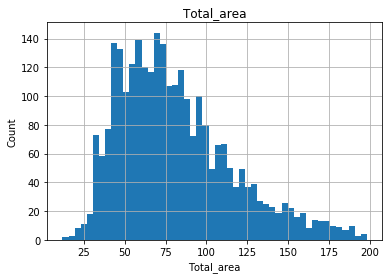

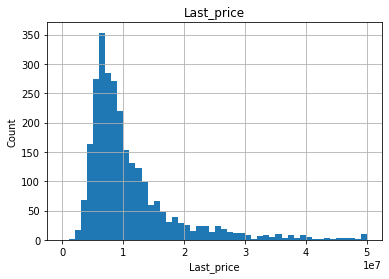

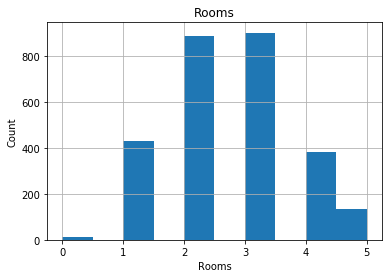

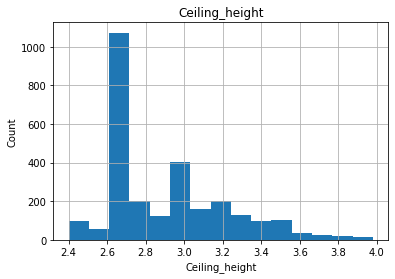

In [24]:
# построение гистограммы по площади квартиры
centre_room_spb['total_area'].hist(bins = 50)
plt.title('Total_area')
plt.xlabel('Total_area')
plt.ylabel('Count')
plt.show()


# построение гистограммы по цене квартиры
centre_room_spb['last_price'].hist(bins = 50, range = (0, 50000000))
plt.title('Last_price')
plt.xlabel('Last_price')
plt.ylabel('Count')
plt.show()

# построение гистограммы по кол-ву комнат
centre_room_spb['rooms'].hist(bins = 10)
plt.title('Rooms')
plt.xlabel('Rooms')
plt.ylabel('Count')
plt.show()

# построение гистограммы по высоте потолка
centre_room_spb['ceiling_height'].hist(bins = 15)
plt.title('Ceiling_height')
plt.xlabel('Ceiling_height')
plt.ylabel('Count')
plt.show()

- наиболее часто встречаются квартиры от 35 до 75 м, т е 1, 2 и 3 комнатные, в отличие от анализа всех объявлений, где наиболее часто встречались квартиры с площадью от 28 до 47 м кв, это студии, 1 и 2-х комн. квартиры;
- наиболее часто встречаются квартиры стоимостью 6 млн в отличие от анализа всех объявлений, где наиболее часто встречались квартиры стоимостью примерно от 2,8 млн до 4,6 млн;
- наиболее часто встречаются квартиры с 2 и 3 комнатами в отличие от анализа всех объявлений, где наиболее часто продаются 1 и 2-ные квартиры;
- наиболее часто встречаются квартиры с высотой потолка от 2,6 м и выше, этот показатель примерно равен значениям при анализе всех объявлений
- ВЫВОД: 
    квартиры в центра дороже почти в 2 раза, имеют больше комнат и площадь.

Средняя взаимосвязь 0.55
Слабая взаимосвязь 0.25
Очень слабая взаимосвязь -0.03


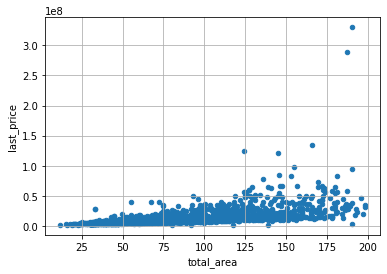

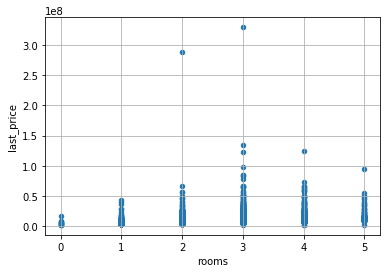

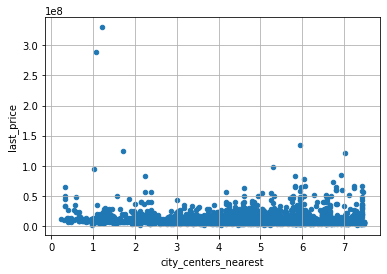

In [25]:
# рассмотрим влияние на стоимость квартиры площади, кол-ва комнат и удаленность от центра 
def corr_price_centr(dt, col_1, col_2):
    cor = dt[col_1].corr(dt[col_2])
    
    if abs(cor) <= 0.2:
        print('Очень слабая взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) <= 0.5:
        print('Слабая взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) <= 0.7:
        print('Средняя взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) <= 0.9:
        print('Высокая взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) > 0.9:
        print('Очень высокая взаимосвязь {}'.format(round(cor, 2)))
    dt.plot(x = col_1, y = col_2, kind='scatter', grid = True)
    

corr_price_centr(centre_room_spb, 'total_area', 'last_price')
corr_price_centr(centre_room_spb, 'rooms', 'last_price')
corr_price_centr(centre_room_spb, 'city_centers_nearest', 'last_price')


- между стоимостью и площадью средняя положительная корреляция- 0.55, что меньше чем в раннее проведенном анализе (0,65). Цены еще меньше зависят от увеличения площади квартиры;
- между стоимостью и кол-вом комнат слабая положительная корреляция - 0.25, что меньше чем в раннее проведенном анализе (0,36). Цены еще меньше зависят от увеличения кол-ва комнат;
- между стоимостью и удаленностью от центра имеется очень слабая отрицательная корреляция - (-0,03), что меньше чем в раннее проведенном анализе (-0,24). Цены почти не зависят от удаленности от центра. Это объяснимо, ведь мы и рассматриваем центр города;

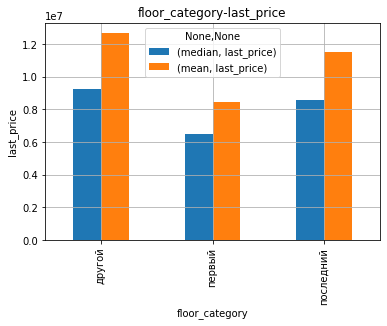

In [26]:
# рассмотрим влияния на стоимость квартиры от этажа 
corr_floor_centr = centre_room_spb.pivot_table(index = 'floor_category', values = 'last_price', aggfunc = ['median', 'mean'])
corr_floor_centr.plot(kind='bar', grid = True, legend = True)
plt.title('floor_category-last_price')
plt.ylabel('last_price')
plt.show()

- стоимость на первом этаже ниже, чем на последнем. Более дорогие квартиры расположены не на первом и не на последнем этажах. Здесь данные аналогичны тем, что и в раннее проведенном анализе.

Очень слабая взаимосвязь -0.00953
Очень слабая взаимосвязь -0.02487
Очень слабая взаимосвязь -0.01656


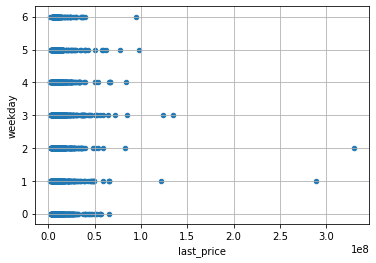

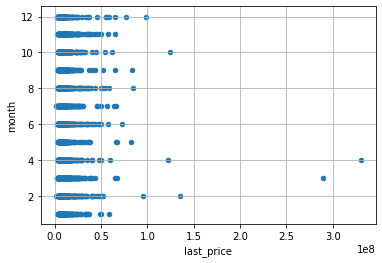

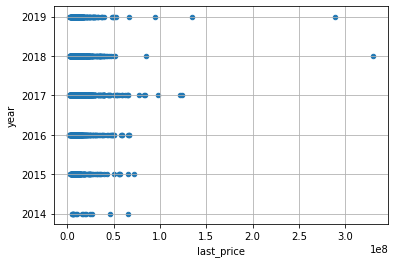

In [27]:
# рассмотрим влияние на стоимость квартиры от даты размещения
def corr_date_centr(dt, col_1, col_2):
    cor = dt[col_1].corr(dt[col_2])
    
    if abs(cor) <= 0.2:
        print('Очень слабая взаимосвязь {}'.format(round(cor, 5)))
    elif abs(cor) <= 0.5:
        print('Слабая взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) <= 0.7:
        print('Средняя взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) <= 0.9:
        print('Высокая взаимосвязь {}'.format(round(cor, 2)))
    elif abs(cor) > 0.9:
        print('Очень высокая взаимосвязь {}'.format(round(cor, 2)))
    dt.plot(x=col_1, y=col_2, kind = 'scatter', grid = True)
    
    
corr_date_centr(centre_room_spb, 'last_price', 'weekday') 
corr_date_centr(centre_room_spb, 'last_price', 'month') 
corr_date_centr(centre_room_spb, 'last_price', 'year') 

- между стоимостью и днями недели, месяца или года корреляция отсутствует. Точно также, что и в раннее проведенном анализе.

### Шаг 5. Общий вывод

- на стоимость квартиры большего всего влияет площадь квартиры, гораздо меньшее влияние оказыват кол-во комнат; 
- по мере удаления от центра города цена ожидаемо снижается; 
- дата размещения объявлений никак не влияет на цену;
- по этажности видно, что самые дешевые предложения по квартирам на 1 этаже, самые дорогие на этажах между 1 и последним; 
- среди 10 населенных пунктах самый дорогой квадр метр в СПБ и Пушкино, свыше 100 тыс за кв м;
- среди 10 населенных пунктах самый дешевый квадр метр в Выборге, ниже 60 тыс за кв м.


### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод